In [46]:
import joblib
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error
import torch.optim as optim
from model import MultimodalRegressor
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tools import plot_loss_function

In [63]:
X_train_text = np.load("data/X_train_text.npy")
X_test_text  = np.load("data/X_test_text.npy")
train = pd.read_csv('data/train_preprocessed.csv')
test = pd.read_csv('data/test_preprocessed.csv')

In [65]:
y_train = train['SalaryNormalized']
y_test = test['SalaryNormalized']
X_train_tab = train.drop(columns=['SalaryNormalized'])
X_test_tab = test.drop(columns=['SalaryNormalized'])

In [66]:
X_train_text = torch.tensor(X_train_text, dtype=torch.float32)
X_test_text = torch.tensor(X_test_text, dtype=torch.float32)

X_train_tab = torch.tensor(X_train_tab.values, dtype=torch.float32)
X_test_tab = torch.tensor(X_test_tab.values, dtype=torch.float32)

y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

In [67]:
def prepare_dataloaders(batch_size, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test):
    train_dataset = TensorDataset(X_train_text, X_train_tab, y_train)
    test_dataset = TensorDataset(X_test_text, X_test_tab, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    return train_loader, test_loader

In [68]:
def train_evaluate(model, optimizer, criterion, epochs, train_loader, test_loader):
    history = {"train_loss": [], "test_loss": []}

    for epoch in range(epochs):
        train_loss = 0.0
        # -----------TRAIN-------------
        model.train()
        for text_batch, tab_batch, y_batch in train_loader:
            optimizer.zero_grad()
            preds = model(text_batch, tab_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * text_batch.size(0)
    
        avg_train_loss = train_loss / len(train_loader.dataset)

        # -----------EVALUATE-------------
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for text_batch, tab_batch, y_batch in test_loader:
                preds_test = model(text_batch, tab_batch)
                loss = criterion(preds_test, y_batch)

                test_loss += loss.item() * text_batch.size(0) 

        avg_test_loss = test_loss / len(test_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs} - test_loss: {avg_test_loss:.4f}")

        history['train_loss'].append(avg_train_loss)
        history['test_loss'].append(avg_test_loss)
        
    return history

In [69]:
model = MultimodalRegressor(text_dim=X_train_text.shape[1], tab_dim=X_train_tab.shape[1])
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 10

In [70]:
train_loader, test_loader = prepare_dataloaders(128, X_train_text, X_train_tab, y_train, X_test_text, X_test_tab, y_test)

In [71]:
history = train_evaluate(model, optimizer, loss_func, epochs, train_loader, test_loader)

Epoch 1/10 - test_loss: 0.3930
Epoch 2/10 - test_loss: 0.3661
Epoch 3/10 - test_loss: 0.3582
Epoch 4/10 - test_loss: 0.3506
Epoch 5/10 - test_loss: 0.3466
Epoch 6/10 - test_loss: 0.3385
Epoch 7/10 - test_loss: 0.3367
Epoch 8/10 - test_loss: 0.3367
Epoch 9/10 - test_loss: 0.3318
Epoch 10/10 - test_loss: 0.3313


In [72]:
print("Train tabular min/max:", train_loader.dataset.tensors[1].min(), train_loader.dataset.tensors[1].max())
print("Test tabular min/max:", test_loader.dataset.tensors[1].min(), test_loader.dataset.tensors[1].max())

Train tabular min/max: tensor(-2.6204) tensor(14.1925)
Test tabular min/max: tensor(-2.6204) tensor(12.2145)


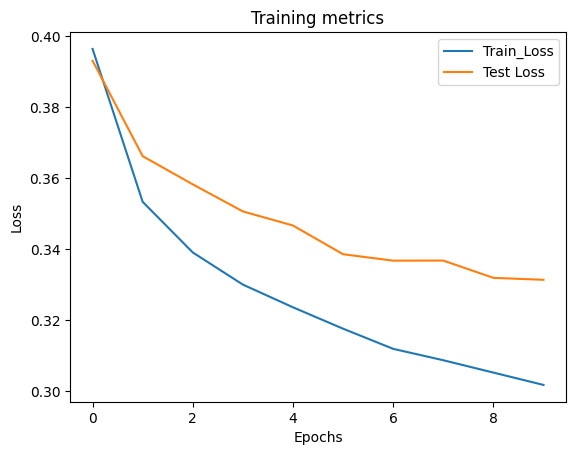

In [73]:
plot_loss_function(history['train_loss'], history['test_loss'])